### Libraries

In [25]:
import torch
import pandas as pd
# import torchvision
import numpy as np
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt
import csv
from loader import FlickrDataset,preprocessing_transforms,get_data_loader,denormalize
from vocab import Vocabulary
from model import EncoderCNN,DecoderRNN,get_acc

In [24]:
import sys
del sys.modules["model"]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Building Vocabulary and Loading our data


In [5]:
vocab = Vocabulary()

In [6]:
vocab.build_vocab()

In [7]:
vocab.save_vocab()

In [8]:
train_data = FlickrDataset('flickr30k_processed/train.csv', vocab = vocab,images_folder='flickr30k_processed/images', transform=preprocessing_transforms())

/Users/nadia/opt/anaconda3/envs/adlproject/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
train_loader = get_data_loader(train_data, batch_size = 32,pad_index=0)

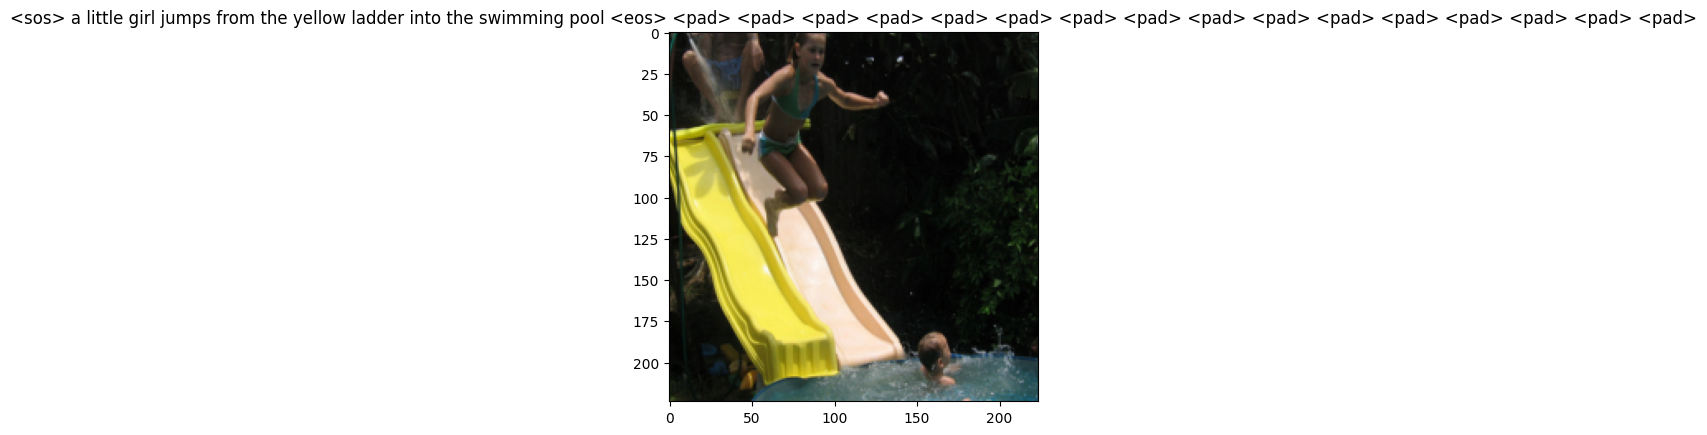

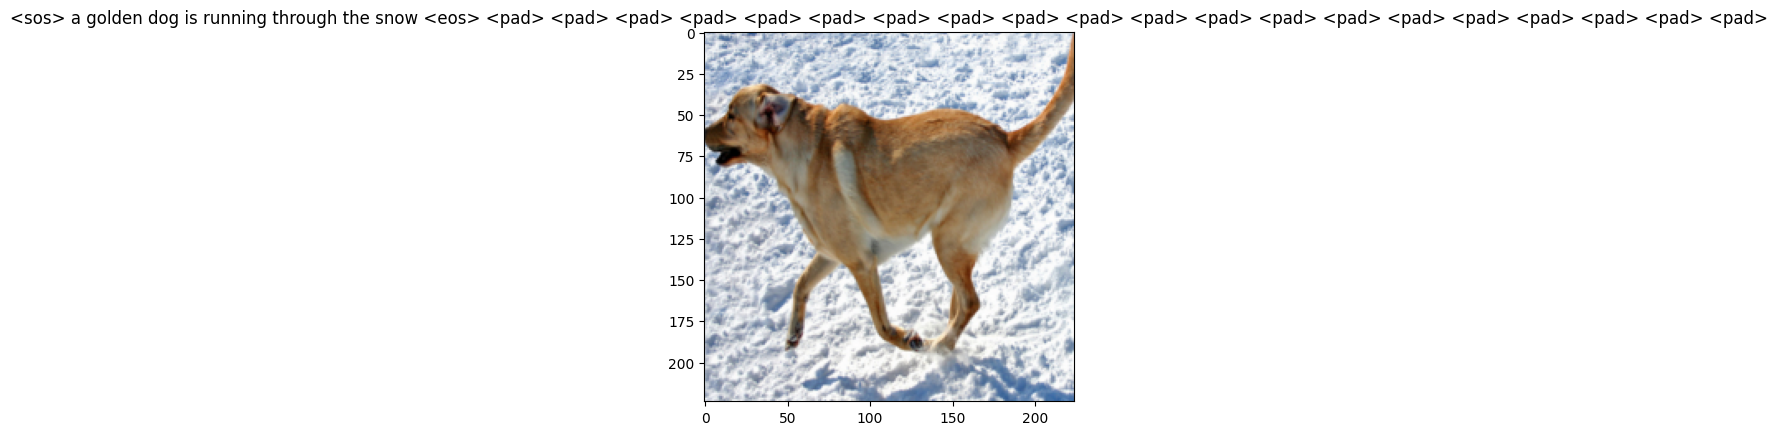

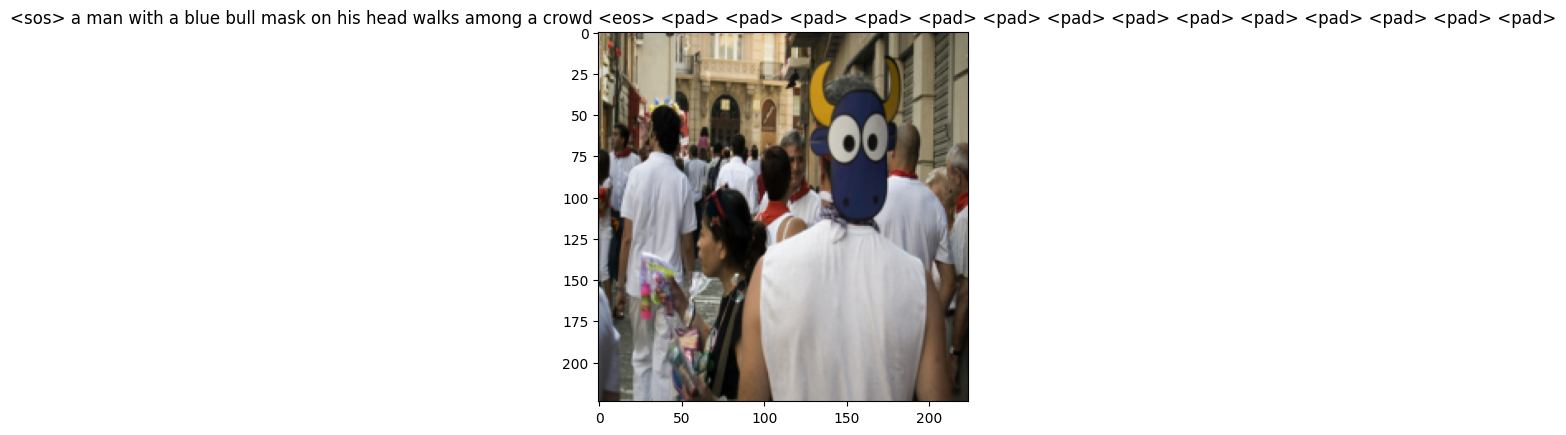

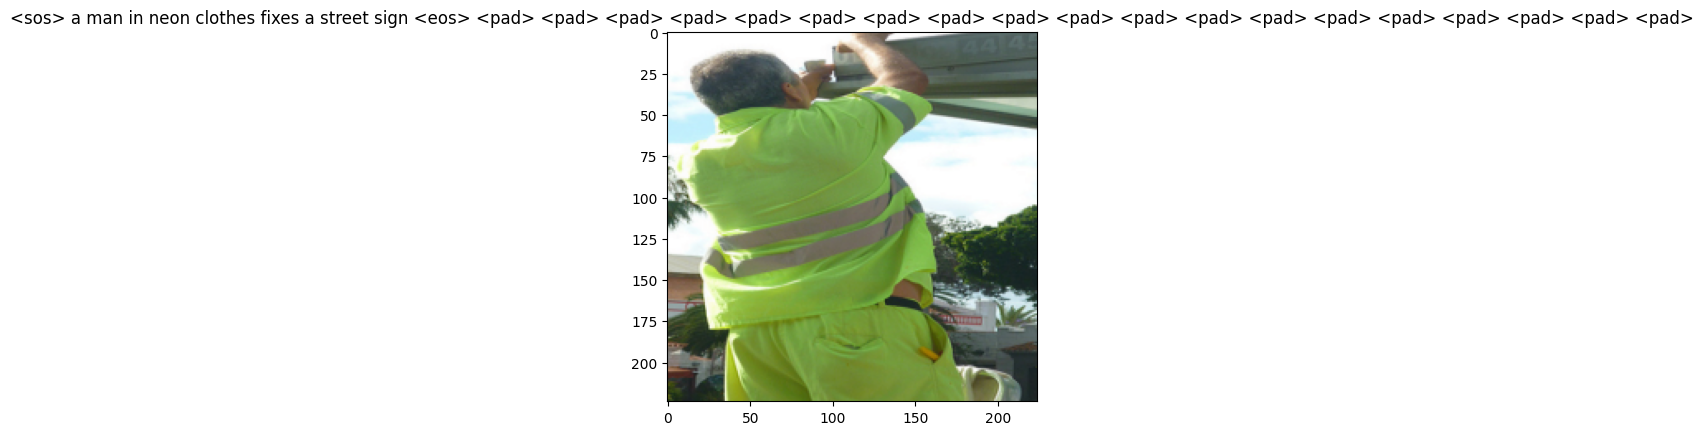

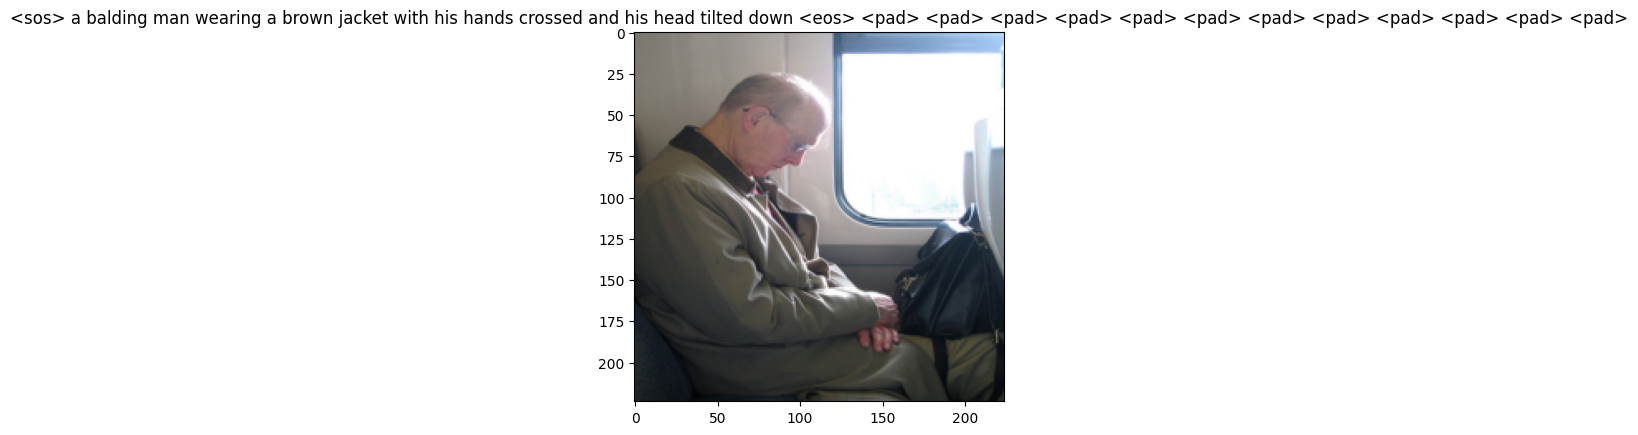

In [10]:
#looking at first 5 images & captions
i= 0
x, y = next(iter(train_loader))
for image, caption in zip(x, y):
    image = denormalize(image)
    caption = [vocab.idx_to_word(int(word_id)) for word_id in caption]
    caption = ' '.join(word for word in caption)
    plt.imshow(image)
    plt.title(caption)
    plt.show()
    plt.pause(1)
    i+=1
    if i ==5:
        break

### Model

In [15]:
encoder = EncoderCNN(image_emb_dim=512,device = device)
emb_layer = torch.nn.Embedding(num_embeddings = 5000, embedding_dim=512,padding_idx=0)

Encoder:
                        Encoder dimension: 512


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/nadia/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:22<00:00, 4.57MB/s]


In [26]:
decoder = DecoderRNN(image_emb_dim = 512,word_emb_dim=512,hidden_dim= 1024,num_layers= 1,vocab_size=5000,device =device)

Decoder:
                        Encoder Size:  512,
                        Embedding Size: 512,
                        LSTM Capacity: 1024,
                        Number of layers: 1,
                        Vocabulary Size: 5000,
                        


In [27]:
 criterion = torch.nn.CrossEntropyLoss()